In [126]:
import yfinance as yf
import pandas as pd
import numpy as np
import hvplot.pandas
from pathlib import Path
from finta import TA
import hvplot.pandas
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import os
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

In [127]:
futoj = yf.Ticker("OJ=F")

futoj_df = futoj.history(period="150d")
futoj_df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2022-04-27,167.850006,173.300003,167.000000,171.199997,666,0,0
2022-04-28,172.000000,175.899994,172.000000,172.899994,190,0,0
2022-04-29,177.000000,182.000000,177.000000,182.399994,595,0,0
2022-05-02,177.750000,177.750000,177.750000,177.750000,0,0,0
2022-05-03,184.149994,184.149994,184.149994,184.149994,0,0,0
...,...,...,...,...,...,...,...
2022-10-12,191.000000,199.699997,189.550003,197.800003,1204,0,0
2022-10-13,198.199997,198.899994,192.850006,193.850006,755,0,0
2022-10-14,193.250000,196.800003,193.100006,195.699997,1155,0,0


In [128]:
futoj_df = futoj_df.drop(columns=["Dividends", "Stock Splits"])

futoj_df

,Open,High,Low,Close,Volume
Date,,,,,
2022-04-27,167.850006,173.300003,167.000000,171.199997,666
2022-04-28,172.000000,175.899994,172.000000,172.899994,190
2022-04-29,177.000000,182.000000,177.000000,182.399994,595
2022-05-02,177.750000,177.750000,177.750000,177.750000,0
2022-05-03,184.149994,184.149994,184.149994,184.149994,0
...,...,...,...,...,...
2022-10-12,191.000000,199.699997,189.550003,197.800003,1204
2022-10-13,198.199997,198.899994,192.850006,193.850006,755
2022-10-14,193.250000,196.800003,193.100006,195.699997,1155


In [129]:
futoj_df["Price Moving AVG"] = futoj_df["Close"].rolling(window=30).mean()

In [130]:
futoj_df["Volume Moving AVG"] = futoj_df["Volume"].rolling(window=30).mean()

futoj_df.head()

,Open,High,Low,Close,Volume,Price Moving AVG,Volume Moving AVG
Date,,,,,,,
2022-04-27,167.850006,173.300003,167.000000,171.199997,666,NaN,NaN
2022-04-28,172.000000,175.899994,172.000000,172.899994,190,NaN,NaN
2022-04-29,177.000000,182.000000,177.000000,182.399994,595,NaN,NaN
2022-05-02,177.750000,177.750000,177.750000,177.750000,0,NaN,NaN
2022-05-03,184.149994,184.149994,184.149994,184.149994,0,NaN,NaN


In [131]:
futoj_df=futoj_df.dropna()

futoj_df

,Open,High,Low,Close,Volume,Price Moving AVG,Volume Moving AVG
Date,,,,,,,
2022-06-08,183.399994,193.500000,182.149994,191.350006,1243,177.908333,532.133333
2022-06-09,188.699997,193.300003,184.149994,184.399994,1055,178.348333,545.100000
2022-06-10,185.399994,187.399994,184.399994,185.050003,425,178.753334,552.933333
2022-06-13,184.399994,184.850006,179.350006,179.800003,1350,178.666667,578.100000
2022-06-14,179.100006,180.550003,178.000000,178.149994,565,178.680000,596.933333
...,...,...,...,...,...,...,...
2022-10-12,191.000000,199.699997,189.550003,197.800003,1204,184.151667,547.833333
2022-10-13,198.199997,198.899994,192.850006,193.850006,755,183.995001,569.933333
2022-10-14,193.250000,196.800003,193.100006,195.699997,1155,184.085001,607.366667


In [132]:
#assumption is that the moving average price is the previous high price, criteria 1 for pullback strategy is price action
futoj_df["Price Lower Than Moving AVG"] = (futoj_df["Price Moving AVG"] > futoj_df["Close"]) * 1.0

In [133]:
#using criteria 2 for pullback strategy is momentum (volume / concentration of movement is in the same direction) 
futoj_df["Volume Higher than Moving AVG"] = (futoj_df["Volume Moving AVG"] > futoj_df["Volume"]) * 1.0

In [134]:
futoj_df.head(15)

,Open,High,Low,Close,Volume,Price Moving AVG,Volume Moving AVG,Price Lower Than Moving AVG,Volume Higher than Moving AVG
Date,,,,,,,,,
2022-06-08,183.399994,193.500000,182.149994,191.350006,1243,177.908333,532.133333,0.0,0.0
2022-06-09,188.699997,193.300003,184.149994,184.399994,1055,178.348333,545.100000,0.0,0.0
2022-06-10,185.399994,187.399994,184.399994,185.050003,425,178.753334,552.933333,0.0,1.0
2022-06-13,184.399994,184.850006,179.350006,179.800003,1350,178.666667,578.100000,0.0,0.0
2022-06-14,179.100006,180.550003,178.000000,178.149994,565,178.680000,596.933333,1.0,1.0
2022-06-15,178.500000,182.000000,177.100006,177.699997,1111,178.465000,633.966667,1.0,0.0
2022-06-16,176.949997,177.500000,174.850006,175.500000,1069,178.363334,669.466667,1.0,0.0
2022-06-17,175.500000,176.550003,172.100006,172.750000,1432,177.878334,717.166667,1.0,0.0
2022-06-21,172.899994,172.899994,170.449997,170.800003,859,177.233334,745.800000,1.0,0.0


In [136]:
t = futoj_df["Volume Moving AVG"].mean()
futoj_df["Volume Moving AVG"] = futoj_df["Volume Moving AVG"]
futoj_df

,Open,High,Low,Close,Volume,Price Moving AVG,Volume Moving AVG,Price Lower Than Moving AVG,Volume Higher than Moving AVG
Date,,,,,,,,,
2022-06-08,183.399994,193.500000,182.149994,191.350006,1243,177.908333,532.133333,0.0,0.0
2022-06-09,188.699997,193.300003,184.149994,184.399994,1055,178.348333,545.100000,0.0,0.0
2022-06-10,185.399994,187.399994,184.399994,185.050003,425,178.753334,552.933333,0.0,1.0
2022-06-13,184.399994,184.850006,179.350006,179.800003,1350,178.666667,578.100000,0.0,0.0
2022-06-14,179.100006,180.550003,178.000000,178.149994,565,178.680000,596.933333,1.0,1.0
...,...,...,...,...,...,...,...,...,...
2022-10-12,191.000000,199.699997,189.550003,197.800003,1204,184.151667,547.833333,0.0,0.0
2022-10-13,198.199997,198.899994,192.850006,193.850006,755,183.995001,569.933333,0.0,0.0
2022-10-14,193.250000,196.800003,193.100006,195.699997,1155,184.085001,607.366667,0.0,0.0


<AxesSubplot:>

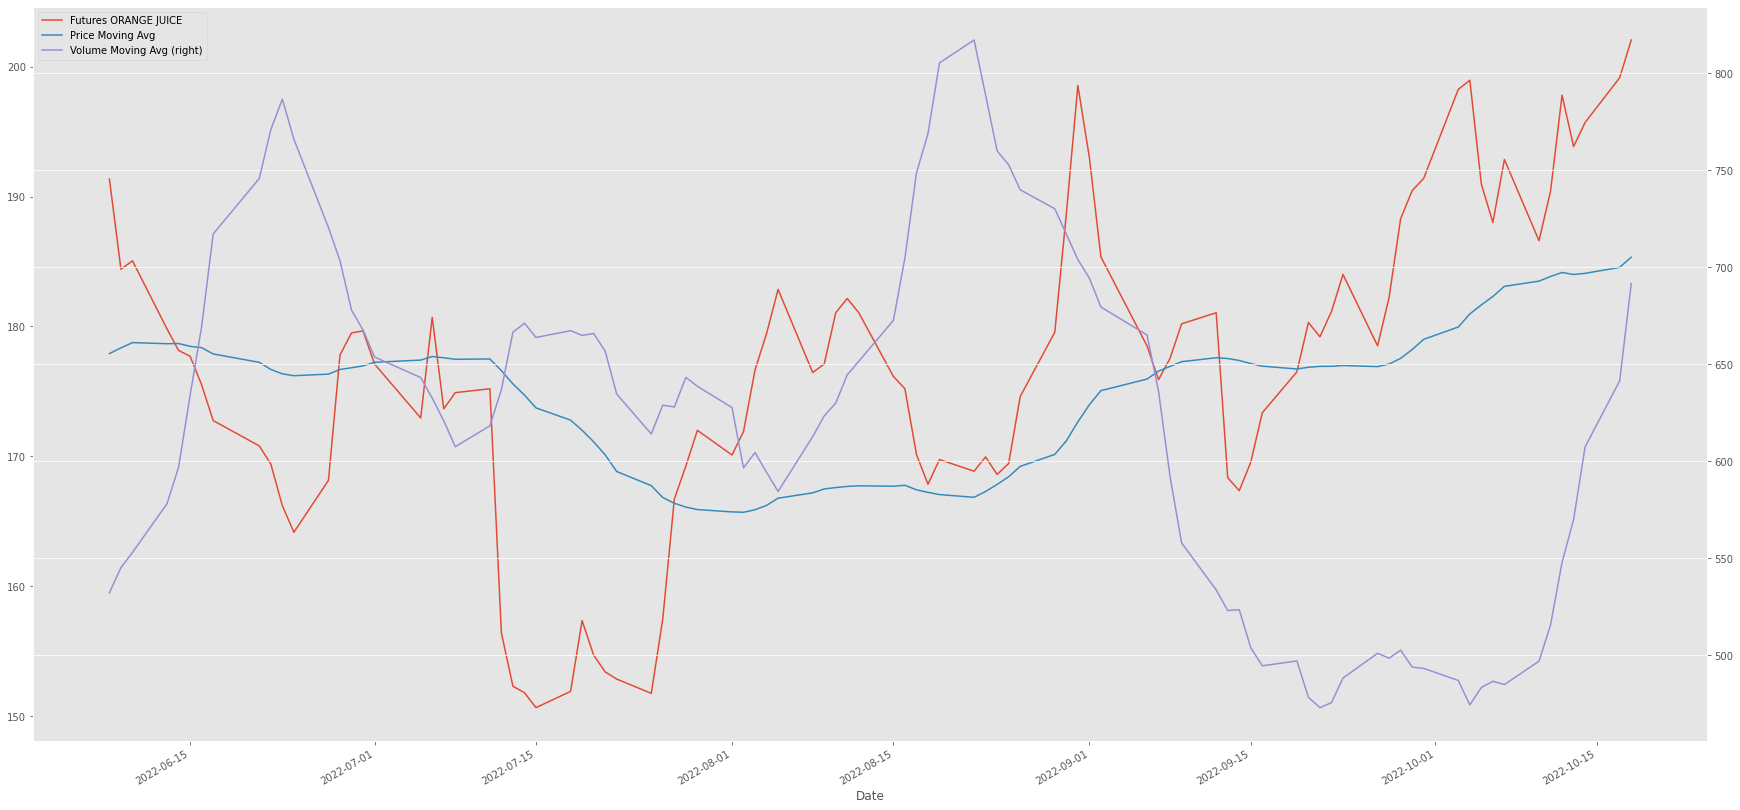

In [82]:
futoj_close_price = futoj_df["Close"]
pmavg = futoj_df["Price Moving AVG"]
vmavg = futoj_df["Volume Moving AVG"]

plt.rc('figure', figsize=(30,15))
plt.style.use('ggplot')

futoj_close_price.plot(label="Futures ORANGE JUICE", legend=True)
pmavg.plot(label='Price Moving Avg', legend=True)
vmavg.plot(secondary_y = True, label="Volume Moving Avg", legend=True)

In [83]:
futoj_signals_df = pd.DataFrame()
futoj_signals_df["Close"] = futoj_df["Close"]
futoj_signals_df["Signal"] = 0.0
futoj_signals_df["Signal"] = futoj_df["Volume Higher than Moving AVG"] * futoj_df["Price Lower Than Moving AVG"]
futoj_signals_df["Signal"] = futoj_signals_df["Signal"].astype(int)
futoj_signals_df["Entry/Exit"] = futoj_signals_df["Signal"].diff()
futoj_signals_df.head(15)


,Close,Signal,Entry/Exit
Date,,,
2022-06-08,191.350006,0,NaN
2022-06-09,184.399994,0,0.0
2022-06-10,185.050003,0,0.0
2022-06-13,179.800003,0,0.0
2022-06-14,178.149994,1,1.0
2022-06-15,177.699997,0,-1.0
2022-06-16,175.500000,0,0.0
2022-06-17,172.750000,0,0.0
2022-06-21,170.800003,0,0.0


In [84]:
# Visualize entry position relative to close price
entry = futoj_signals_df[futoj_signals_df["Entry/Exit"] == 1.0]["Close"].hvplot.scatter(
    color='purple',
    marker='^',
    size=200,
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize exit position relative to close price
exit = futoj_signals_df[futoj_signals_df["Entry/Exit"] == -1.0]["Close"].hvplot.scatter(
    color='orange',
    marker='v',
    size=200,
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize close price for the futures contract
security_close = futoj_signals_df[["Close"]].hvplot(
    line_color='lightgray',
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize weighted moving averages
moving_avgs = futoj_df[["Price Moving AVG"]].hvplot(
    ylabel='Price in $',
    width=1000,
    height=400
)

# Overlay plots
entry_exit_plot = security_close * moving_avgs * entry * exit
entry_exit_plot

:Overlay
   .Curve.I          :Curve   [Date]   (Close)
   .Curve.II         :Curve   [Date]   (Price Moving AVG)
   .Scatter.Close.I  :Scatter   [Date]   (Close)
   .Scatter.Close.II :Scatter   [Date]   (Close)

In [85]:
z = 1
profit_or_loss = 0.00
starting_price = (futoj_df['Close'].head(1))
starting_price = float(starting_price)

ending_price = (futoj_df['Close'].tail(1))
ending_price = float(ending_price)

#returns = (profit_or_loss / starting_price)
#return_pct = "{:.2%}".format(returns)

In [86]:
print("Futures ORANGE JUICE Pullback Trading Results:", "\n")
print("The starting price is: $", round(starting_price,2))
print("The ending price is: $", round(ending_price,2), "\n")

#Getting buy and sell dates
for index, row in futoj_signals_df.iterrows():
 #   if row['Volume Higher than Weighted Moving AVG'] == 1:
       # if row['Price Lower Than Weighted Moving AVG'] == 1:
    if row['Signal'] == 1:
        if row['Entry/Exit'] != -1:
            if z == 1:
                print (index, round(row['Close'],2), '- Buy')
                close = row['Close']
                profit_or_loss = profit_or_loss - close
                z = z - 1
                
    else:
     #   if row['Volume Higher than Weighted Moving AVG'] == 0:
      #      if row['Price Lower Than Weighted Moving AVG'] == 0:
            if row['Entry/Exit'] == -1:
                if z == 0:
                    print (index, round(row['Close'],2), '- Sell')
                    close = row['Close'] 
                    profit_or_loss = profit_or_loss + close
                    returns = (profit_or_loss / starting_price)
                    return_pct = "{:.2%}".format(returns)
                    print ("Total Profit/Loss is $",round(profit_or_loss,2))
                    print ("Total Return Percentage is", return_pct, "\n")
                    z = z + 1
                    

                    
entire_hold_return = (ending_price - starting_price)
entire_hold_pct = "{:.2%}".format((ending_price - starting_price) / starting_price)
print("The return for holding for the entire period was $",round(entire_hold_return,2), "or", entire_hold_pct, ".")
profit_or_loss = 0.00      

Futures ORANGE JUICE Pullback Trading Results: 

The starting price is: $ 191.35
The ending price is: $ 202.05 

2022-06-14 00:00:00 178.15 - Buy
2022-06-15 00:00:00 177.7 - Sell
Total Profit/Loss is $ -0.45
Total Return Percentage is -0.24% 

2022-06-24 00:00:00 164.15 - Buy
2022-06-28 00:00:00 177.8 - Sell
Total Profit/Loss is $ 13.2
Total Return Percentage is 6.90% 

2022-07-01 00:00:00 177.1 - Buy
2022-07-06 00:00:00 180.7 - Sell
Total Profit/Loss is $ 16.8
Total Return Percentage is 8.78% 

2022-07-07 00:00:00 173.65 - Buy
2022-07-12 00:00:00 156.4 - Sell
Total Profit/Loss is $ -0.45
Total Return Percentage is -0.24% 

2022-07-18 00:00:00 151.9 - Buy
2022-07-26 00:00:00 157.5 - Sell
Total Profit/Loss is $ 5.15
Total Return Percentage is 2.69% 

2022-09-07 00:00:00 175.9 - Buy
2022-09-08 00:00:00 177.55 - Sell
Total Profit/Loss is $ 6.8
Total Return Percentage is 3.55% 

2022-09-13 00:00:00 168.35 - Buy
2022-09-15 00:00:00 169.55 - Sell
Total Profit/Loss is $ 8.0
Total Return Perce

In [87]:
futoj_price_plot = futoj_df["Close"].hvplot.line(title="FUT ORANGE JUICE Price")
futoj_price_plot

:Curve   [Date]   (Close)

In [88]:
futoj_price = futoj_df[['Close']]
scaler = MinMaxScaler(feature_range=(-1,1))
futoj_price['Close']=scaler.fit_transform(futoj_price['Close'].values.reshape(-1,1))

In [89]:
def split_data(stock, lookback):
    data_raw = stock.to_numpy() # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback])
    
    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]
lookback = 20 # choose sequence length
x_train, y_train, x_test, y_test = split_data(futoj_price, lookback)

In [90]:
import torch
import torch.nn as nn
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)
y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor)
y_train_gru = torch.from_numpy(y_train).type(torch.Tensor)
y_test_gru = torch.from_numpy(y_test).type(torch.Tensor)

In [91]:
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 100

In [92]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [93]:
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

In [94]:
import time
hist = np.zeros(num_epochs)
start_time = time.time()
lstm = []
for t in range(num_epochs):
    y_train_pred = model(x_train)
    loss = criterion(y_train_pred, y_train_lstm)
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
    
training_time = time.time()-start_time
print("Training time: {}".format(training_time))

Epoch  0 MSE:  0.17834168672561646
Epoch  1 MSE:  0.17677494883537292
Epoch  2 MSE:  0.16216368973255157
Epoch  3 MSE:  0.15686863660812378
Epoch  4 MSE:  0.1462998390197754
Epoch  5 MSE:  0.13012176752090454
Epoch  6 MSE:  0.12819139659404755
Epoch  7 MSE:  0.11338423192501068
Epoch  8 MSE:  0.10438884794712067
Epoch  9 MSE:  0.09397636353969574
Epoch  10 MSE:  0.07910614460706711
Epoch  11 MSE:  0.06949915736913681
Epoch  12 MSE:  0.06330068409442902
Epoch  13 MSE:  0.05613405629992485
Epoch  14 MSE:  0.054193295538425446
Epoch  15 MSE:  0.05485152825713158
Epoch  16 MSE:  0.054126668721437454
Epoch  17 MSE:  0.05341564863920212
Epoch  18 MSE:  0.04645225405693054
Epoch  19 MSE:  0.04293331131339073
Epoch  20 MSE:  0.04030047729611397
Epoch  21 MSE:  0.039573606103658676
Epoch  22 MSE:  0.03944103419780731
Epoch  23 MSE:  0.03761874884366989
Epoch  24 MSE:  0.03659040108323097
Epoch  25 MSE:  0.035207606852054596
Epoch  26 MSE:  0.03368125855922699
Epoch  27 MSE:  0.0329003781080246


In [95]:
futoj_lstm_prediction_df = pd.DataFrame(scaler.inverse_transform(y_train_pred.detach().numpy()))
futoj_lstm_original_df = pd.DataFrame(scaler.inverse_transform(y_train_lstm.detach().numpy()))
futoj_lstm_test_df = pd.DataFrame(scaler.inverse_transform(y_test_lstm.detach().numpy()))

In [96]:
lstm_futoj_plot= futoj_lstm_prediction_df.hvplot(label="LSTM Training Prediction Price") * futoj_lstm_original_df.hvplot(label="Actual Price") * futoj_lstm_test_df.hvplot(label="LSTM Test Prediction Price") 
lstm_futoj_plot

:Overlay
   .Curve.LSTM_Training_Prediction_Price :Curve   [index]   (0)
   .Curve.Actual_Price                   :Curve   [index]   (0)
   .Curve.LSTM_Test_Prediction_Price     :Curve   [index]   (0)

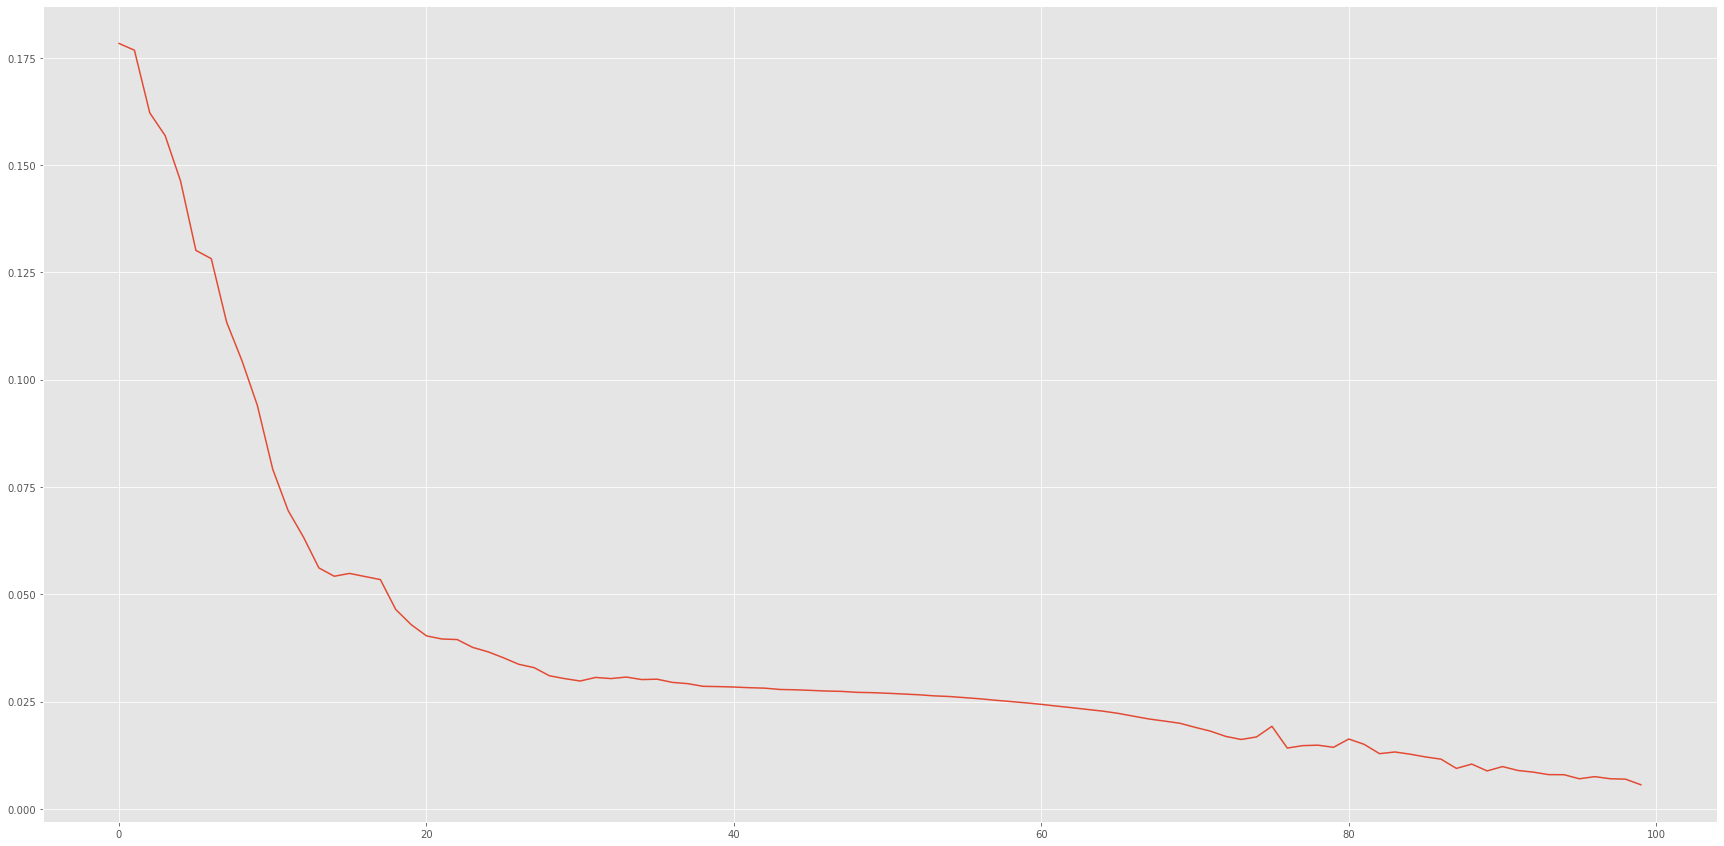

In [97]:
futoj_lstm_training_loss_plot = plt.plot(hist)
futoj_lstm_training_loss_plot

In [98]:
import math, time
from sklearn.metrics import mean_squared_error

# make predictions
y_test_pred = model(x_test)

# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train_lstm.detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test_lstm.detach().numpy())

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
lstm.append(trainScore)
lstm.append(testScore)
lstm.append(training_time)

Train Score: 1.93 RMSE
Test Score: 11.34 RMSE


In [99]:
futoj_df

,Open,High,Low,Close,Volume,Price Moving AVG,Volume Moving AVG,Price Lower Than Moving AVG,Volume Higher than Moving AVG
Date,,,,,,,,,
2022-06-08,183.399994,193.500000,182.149994,191.350006,1243,177.908333,532.133333,0.0,0.0
2022-06-09,188.699997,193.300003,184.149994,184.399994,1055,178.348333,545.100000,0.0,0.0
2022-06-10,185.399994,187.399994,184.399994,185.050003,425,178.753334,552.933333,0.0,1.0
2022-06-13,184.399994,184.850006,179.350006,179.800003,1350,178.666667,578.100000,0.0,0.0
2022-06-14,179.100006,180.550003,178.000000,178.149994,565,178.680000,596.933333,1.0,1.0
...,...,...,...,...,...,...,...,...,...
2022-10-12,191.000000,199.699997,189.550003,197.800003,1204,184.151667,547.833333,0.0,0.0
2022-10-13,198.199997,198.899994,192.850006,193.850006,755,183.995001,569.933333,0.0,0.0
2022-10-14,193.250000,196.800003,193.100006,195.699997,1155,184.085001,607.366667,0.0,0.0


In [100]:
futoj_df2=futoj_df

In [101]:
pd.options.mode.chained_assignment = None

In [102]:
futoj_df["Open"] = pd.to_numeric(futoj_df["Open"])
futoj_df["Open"].describe()

count     92.000000
mean     176.227717
std       11.971639
min      150.800003
25%      170.000000
50%      176.974998
75%      183.649994
max      199.949997
Name: Open, dtype: float64

In [103]:
futoj_df["High"] = pd.to_numeric(futoj_df["High"])
futoj_df["High"].describe()

count     92.000000
mean     178.911412
std       12.234243
min      153.300003
25%      172.087498
50%      178.900002
75%      184.924995
max      202.149994
Name: High, dtype: float64

In [104]:
futoj_df["Low"] = pd.to_numeric(futoj_df["Low"])
futoj_df["Low"].describe()

count     92.000000
mean     174.407066
std       11.683422
min      150.500000
25%      167.687496
50%      175.300003
75%      181.250004
max      198.550003
Name: Low, dtype: float64

In [105]:
futoj_df["Close"] = pd.to_numeric(futoj_df["Close"])
futoj_df["Close"].describe()

count     92.000000
mean     176.589130
std       12.170709
min      150.649994
25%      169.525002
50%      177.100006
75%      183.137505
max      202.050003
Name: Close, dtype: float64

In [106]:
futoj_df["Price Moving AVG"] = pd.to_numeric(futoj_df["Price Moving AVG"])
futoj_df["Price Moving AVG"].describe()

count     92.000000
mean     174.621811
std        5.519031
min      165.689998
25%      168.277916
50%      176.705834
75%      177.610417
max      185.330000
Name: Price Moving AVG, dtype: float64

In [107]:
futoj_df["Volume Moving AVG"] = pd.to_numeric(futoj_df["Volume Moving AVG"])
futoj_df["Volume Moving AVG"].describe()

count     92.000000
mean     621.637681
std       91.999239
min      472.900000
25%      542.225000
50%      631.233333
75%      673.925000
max      817.200000
Name: Volume Moving AVG, dtype: float64

In [108]:
futoj_df["Volume"] = pd.to_numeric(futoj_df["Volume"])
futoj_df["Volume"].describe()

count      92.000000
mean      667.586957
std       406.873638
min         0.000000
25%       411.250000
50%       624.000000
75%       973.000000
max      1646.000000
Name: Volume, dtype: float64

In [109]:
#futoj_df= pd.get_dummies(futoj_df, columns=['Price Lower Than Moving AVG', "Volume Higher than Moving AVG"])
futoj_df= futoj_df.astype(float)
futoj_df

,Open,High,Low,Close,Volume,Price Moving AVG,Volume Moving AVG,Price Lower Than Moving AVG,Volume Higher than Moving AVG
Date,,,,,,,,,
2022-06-08,183.399994,193.500000,182.149994,191.350006,1243.0,177.908333,532.133333,0.0,0.0
2022-06-09,188.699997,193.300003,184.149994,184.399994,1055.0,178.348333,545.100000,0.0,0.0
2022-06-10,185.399994,187.399994,184.399994,185.050003,425.0,178.753334,552.933333,0.0,1.0
2022-06-13,184.399994,184.850006,179.350006,179.800003,1350.0,178.666667,578.100000,0.0,0.0
2022-06-14,179.100006,180.550003,178.000000,178.149994,565.0,178.680000,596.933333,1.0,1.0
...,...,...,...,...,...,...,...,...,...
2022-10-12,191.000000,199.699997,189.550003,197.800003,1204.0,184.151667,547.833333,0.0,0.0
2022-10-13,198.199997,198.899994,192.850006,193.850006,755.0,183.995001,569.933333,0.0,0.0
2022-10-14,193.250000,196.800003,193.100006,195.699997,1155.0,184.085001,607.366667,0.0,0.0


In [110]:
futoj_df[['Open']] = preprocessing.scale(futoj_df[['Open']])
futoj_df[['High']] = preprocessing.scale(futoj_df[['High']])
futoj_df[['Low']] = preprocessing.scale(futoj_df[['Low']])
futoj_df[['Close']] = preprocessing.scale(futoj_df[['Close']])
futoj_df[['Volume']] = preprocessing.scale(futoj_df[['Volume']])
futoj_df[['Price Moving AVG']] = preprocessing.scale(futoj_df[['Price Moving AVG']])
futoj_df[['Volume Moving AVG']] = preprocessing.scale(futoj_df[['Volume Moving AVG']])
# futoj_df[['Price Lower Than Moving AVG']] = preprocessing.scale(futoj_df[['Price Lower Than Moving AVG']])
# futoj_df[['Volume Higher than Moving AVG']] = preprocessing.scale(futoj_df[['Volume Higher than Moving AVG']])
futoj_df

,Open,High,Low,Close,Volume,Price Moving AVG,Volume Moving AVG,Price Lower Than Moving AVG,Volume Higher than Moving AVG
Date,,,,,,,,,
2022-06-08,0.602388,1.198973,0.666359,1.219465,1.421980,0.598752,-0.978212,0.0,0.0
2022-06-09,1.047528,1.182536,0.838480,0.645292,0.957388,0.678913,-0.836497,0.0,0.0
2022-06-10,0.770365,0.697640,0.859995,0.698993,-0.599489,0.752698,-0.750885,0.0,1.0
2022-06-13,0.686377,0.488067,0.425391,0.265265,1.686402,0.736908,-0.475833,0.0,0.0
2022-06-14,0.241239,0.134669,0.309209,0.128950,-0.253516,0.739337,-0.269999,1.0,1.0
...,...,...,...,...,...,...,...,...,...
2022-10-12,1.240701,1.708524,1.303207,1.752330,1.325602,1.736188,-0.806624,0.0,0.0
2022-10-13,1.845418,1.642775,1.587206,1.426002,0.216018,1.707646,-0.565088,0.0,0.0
2022-10-14,1.429675,1.470186,1.608721,1.578839,1.204511,1.724042,-0.155971,0.0,0.0


In [111]:
target_price = futoj_df[['Close']]
target_price = target_price.astype(float)

In [112]:
X_train, X_test, y_train, y_test = train_test_split(futoj_df, target_price, test_size = 0.2, random_state = 7)

In [113]:
dtype= torch.float
X_train_tensor = torch.tensor(X_train.values, dtype=dtype)
X_test_tensor = torch.tensor(X_test.values, dtype=dtype)

y_train_tensor = torch.tensor(y_train.values, dtype=dtype)
y_test_tensor = torch.tensor(y_test.values, dtype=dtype)

In [114]:
inp = 9
out = 1
hid = 100
loss_fn = torch.nn.MSELoss()
learning_rate = 0.0001

In [115]:
model = torch.nn.Sequential(torch.nn.Linear(inp, hid),
                           torch.nn.Sigmoid(),
                           torch.nn.Linear(hid, out))

In [116]:
for iter in range(10000):
    y_pred = model(X_train_tensor)
    loss = loss_fn(y_pred, y_train_tensor)
    
    if iter % 1000 == 0:
        print(iter, loss.item())
        
    model.zero_grad()
    loss.backward()
    
    with torch.no_grad():
        for param in model.parameters():
            param -= learning_rate * param.grad

0 1.0198774337768555
1000 0.7316165566444397
2000 0.5261338949203491
3000 0.37878403067588806
4000 0.2738189697265625
5000 0.19987989962100983
6000 0.14841273427009583
7000 0.11294092237949371
8000 0.08863961696624756
9000 0.07200151681900024


In [117]:
torch.save(model, 'fut orange juice price')

In [118]:
saved_model = torch.load('fut orange juice price')

In [119]:
y_pred_tensor = saved_model(X_test_tensor)

In [120]:
y_pred = y_pred_tensor.detach().numpy()

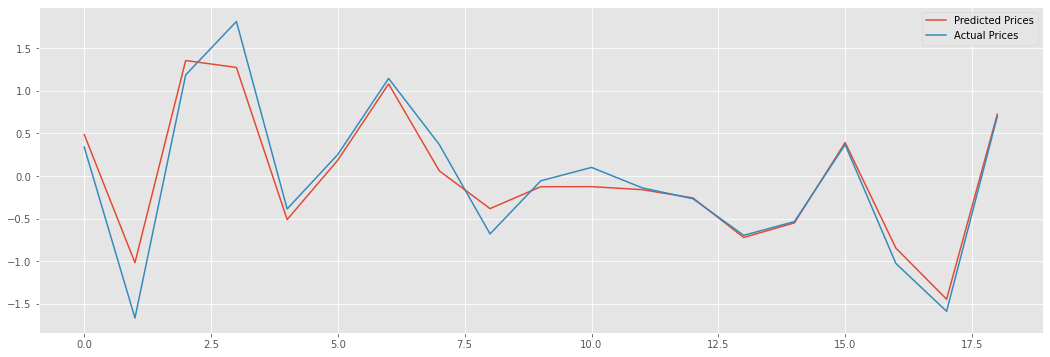

In [121]:
plt.figure(figsize=(18,6))
plt.plot(y_pred, label='Predicted Prices')
plt.plot(y_test.values, label = 'Actual Prices')

plt.legend()
plt.show()

In [122]:
y_test

,Close
Date,
2022-07-06,0.339618
2022-07-12,-1.667920
2022-10-05,1.186419
2022-08-31,1.814291
2022-08-02,-0.387392
2022-06-30,0.252872
2022-09-29,1.145111
2022-08-10,0.368534
2022-09-13,-0.680673


In [123]:
y_pred

array([[ 0.48658806],
       [-1.0185579 ],
       [ 1.3558284 ],
       [ 1.2742015 ],
       [-0.5123443 ],
       [ 0.18666065],
       [ 1.0809624 ],
       [ 0.06003249],
       [-0.38360456],
       [-0.12647942],
       [-0.12559646],
       [-0.16093487],
       [-0.2586113 ],
       [-0.722808  ],
       [-0.5508003 ],
       [ 0.39192155],
       [-0.8469225 ],
       [-1.4476515 ],
       [ 0.7252082 ]], dtype=float32)